In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import math
import pandas as pd

torch.manual_seed(1)

In [2]:
fil='/Users/uzi720/Desktop/'
data=pd.read_csv(fil+"tsIE.csv",sep=';')

data['Sessions']=data['Sessions'].astype('float')
data['str']=data['Month of Year'].astype(str)
data['year']=data['str'].str[:4]
data['month']=data['str'].str[4:]
print(data.dtypes)
data.head()
data.tail()

Month of Year      int64
Sessions         float64
str               object
year              object
month             object
dtype: object


,Month of Year,Sessions,str,year,month
79,201508,154854.0,201508,2015,08
80,201509,100407.0,201509,2015,09
81,201510,96439.0,201510,2015,10
82,201511,79689.0,201511,2015,11
83,201512,99689.0,201512,2015,12


In [4]:
result = data.groupby(['year'], as_index=False).agg(
                      {'Sessions':['mean','std']})
print(result)
print(result.columns)
year=result['year']
print(type(year))
yrs=year.values.tolist()

mean=result['Sessions']['mean']
std=result['Sessions']['std']
yr_mu=mean.values.tolist()
yr_std=std.values.tolist()
print(type(yrs[0]),type(yr_mu[0]), type(yr_std[0]))
print(type(data.iloc[0,3]),data.iloc[0,3],type(data.iloc[0,1]),data.iloc[0,1]) 


   year       Sessions              
                  mean           std
0  2009   81125.666667  19857.182943
1  2010  101085.083333  34454.598082
2  2011  101923.750000  23524.255583
3  2012  102986.000000  26878.443242
4  2013  118917.083333  27364.116352
5  2014  113627.250000  35534.987438
6  2015  127608.166667  32894.264169
MultiIndex(levels=[[u'Sessions', u'year'], [u'mean', u'std', u'']],
           labels=[[1, 0, 0], [2, 0, 1]])
<class 'pandas.core.series.Series'>
(<type 'str'>, <type 'float'>, <type 'float'>)
(<type 'str'>, '2009', <type 'numpy.float64'>, 66953.0)


In [5]:
data['Sessions'].plot()
cuts=[data['Sessions'].quantile(.1*i) for i in range(0,10)]
print cuts , data['Sessions'].quantile(.90)




[52735.0, 69856.2, 77730.8, 87020.1, 94290.20000000001, 100113.0, 108201.00000000003, 124658.0, 136022.2, 151519.7] 151519.7


In [6]:
# convert Session data to symbols from a,b,c,d,e,f,g,h,i,j
symbols=[]
for idx in data.index:
    if data.iloc[idx,1]< cuts[0]:
        symbols.append('a')
    elif (data.iloc[idx,1]>=cuts[0] and data.iloc[idx,1] < cuts[1]):
        symbols.append('b')
    elif (data.iloc[idx,1]>=cuts[1] and data.iloc[idx,1] < cuts[2]):
        symbols.append('c')
    elif (data.iloc[idx,1]>=cuts[2] and data.iloc[idx,1] < cuts[3]):
        symbols.append('d')
    elif (data.iloc[idx,1]>=cuts[3] and data.iloc[idx,1] < cuts[4]):
        symbols.append('e')
    elif (data.iloc[idx,1]>=cuts[4] and data.iloc[idx,1] < cuts[5]):
        symbols.append('f')
    elif (data.iloc[idx,1]>=cuts[5] and data.iloc[idx,1] < cuts[6]):
        symbols.append('g')
    elif (data.iloc[idx,1]>=cuts[6] and data.iloc[idx,1] < cuts[7]):
        symbols.append('h')
    elif (data.iloc[idx,1]>=cuts[7] and data.iloc[idx,1] < cuts[8]):
        symbols.append('i')
    elif (data.iloc[idx,1]>=cuts[8] and data.iloc[idx,1] < cuts[9]):
        symbols.append('j')
    else :
        symbols.append('k')
print(len(symbols),symbols)

(84, ['b', 'b', 'e', 'd', 'g', 'g', 'h', 'f', 'c', 'b', 'b', 'b', 'c', 'c', 'f', 'k', 'j', 'g', 'h', 'h', 'd', 'c', 'b', 'd', 'e', 'e', 'f', 'f', 'i', 'i', 'i', 'j', 'e', 'd', 'c', 'b', 'g', 'e', 'g', 'h', 'h', 'i', 'j', 'j', 'e', 'd', 'b', 'b', 'h', 'g', 'i', 'h', 'i', 'j', 'k', 'k', 'e', 'f', 'c', 'e', 'g', 'd', 'f', 'i', 'i', 'k', 'k', 'j', 'd', 'e', 'c', 'c', 'j', 'h', 'k', 'h', 'j', 'k', 'k', 'k', 'g', 'f', 'd', 'f'])


In [7]:
data['symbols']=symbols
data.head()

,Month of Year,Sessions,str,year,month,symbols
0,200901,66953.0,200901,2009,01,b
1,200902,61591.0,200902,2009,02,b
2,200903,87241.0,200903,2009,03,e
3,200904,85263.0,200904,2009,04,d
4,200905,100813.0,200905,2009,05,g


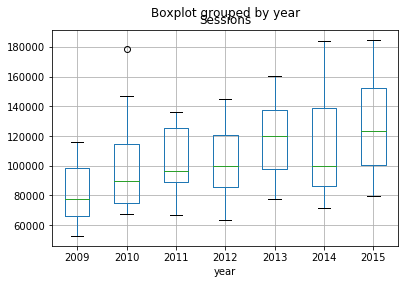

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
data.boxplot(by='year',column="Sessions")

In [9]:
# arbitray create target labels if a data point falls above .90 quantile
outlier=data[data['Sessions'] > data['Sessions'].quantile(.90)]

targets=[]
for idx in data.index:
    if idx in outlier.index :
        targets.append(1)
    else:
        targets.append(0)
# check it indeed is 84 data points
print(len(targets))
print(set(targets))

84
set([0, 1])


In [10]:
lookup_symbols=dict(zip(data['Sessions'],data['symbols']))
lookup_symbols.items()


[(87042.0, 'e'),
 (100100.0, 'f'),
 (84997.0, 'd'),
 (68835.0, 'b'),
 (66953.0, 'b'),
 (160778.0, 'k'),
 (63127.0, 'b'),
 (98061.0, 'f'),
 (85263.0, 'd'),
 (94170.0, 'e'),
 (76179.0, 'c'),
 (120469.0, 'h'),
 (151190.0, 'j'),
 (61591.0, 'b'),
 (184984.0, 'k'),
 (98969.0, 'f'),
 (67868.0, 'b'),
 (105117.0, 'g'),
 (100126.0, 'g'),
 (151173.0, 'j'),
 (145056.0, 'j'),
 (183856.0, 'k'),
 (88866.0, 'e'),
 (151661.0, 'k'),
 (79689.0, 'd'),
 (115623.0, 'h'),
 (137000.0, 'j'),
 (127260.0, 'i'),
 (124586.0, 'h'),
 (93639.0, 'e'),
 (100268.0, 'g'),
 (75694.0, 'c'),
 (77872.0, 'd'),
 (86823.0, 'd'),
 (94771.0, 'f'),
 (130357.0, 'i'),
 (100534.0, 'g'),
 (87305.0, 'e'),
 (136159.0, 'j'),
 (96439.0, 'f'),
 (140222.0, 'j'),
 (113141.0, 'h'),
 (71488.0, 'c'),
 (70083.0, 'c'),
 (134340.0, 'i'),
 (132918.0, 'i'),
 (101959.0, 'g'),
 (111176.0, 'h'),
 (87241.0, 'e'),
 (92874.0, 'e'),
 (100407.0, 'g'),
 (100813.0, 'g'),
 (152014.0, 'k'),
 (63757.0, 'b'),
 (108972.0, 'h'),
 (115923.0, 'h'),
 (78804.0, 'd'),
 

In [11]:
train_data=[]
data['targets']=targets


yrs=data['year'].unique().tolist()
for yr in yrs:
    
    temp=([lookup_symbols[x] for x in data.loc[(data.year==yr)]['Sessions'].values.tolist()],data.loc[(data.year==yr)]['targets'].values.tolist())
    tmp=(list(set(temp[0])),  [1 if 'k' in temp[1] else 0])
    print(tmp)
    train_data.append(temp)

print(train_data)


(['c', 'b', 'e', 'd', 'g', 'f', 'h'], [0])
(['c', 'b', 'd', 'g', 'f', 'h', 'k', 'j'], [1])
(['c', 'b', 'e', 'd', 'f', 'i', 'j'], [0])
(['b', 'e', 'd', 'g', 'i', 'h', 'j'], [0])
(['c', 'e', 'g', 'f', 'i', 'h', 'k', 'j'], [1])
(['c', 'e', 'd', 'g', 'f', 'i', 'k', 'j'], [1])
(['d', 'g', 'f', 'h', 'k', 'j'], [1])
[(['b', 'b', 'e', 'd', 'g', 'g', 'h', 'f', 'c', 'b', 'b', 'b'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (['c', 'c', 'f', 'k', 'j', 'g', 'h', 'h', 'd', 'c', 'b', 'd'], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), (['e', 'e', 'f', 'f', 'i', 'i', 'i', 'j', 'e', 'd', 'c', 'b'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (['g', 'e', 'g', 'h', 'h', 'i', 'j', 'j', 'e', 'd', 'b', 'b'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (['h', 'g', 'i', 'h', 'i', 'j', 'k', 'k', 'e', 'f', 'c', 'e'], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]), (['g', 'd', 'f', 'i', 'i', 'k', 'k', 'j', 'd', 'e', 'c', 'c'], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]), (['j', 'h', 'k', 'h', 'j', 'k', 'k', 'k', 'g', 'f', 'd', 'f'], [0, 0, 1, 0, 

In [ ]:
len(train_data), len(data['year'].unique())

In [36]:
### use the same technique to convert your words into dictionaries 
"""
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
print("training_data",training_data)
"""
word_to_ix = {}
for sent, tags in train_data:
    #print("sent:{}, tags:{}".format(sent,tags))
    for word in sent:
        #print("word:{}".format(word))
        #print("word_to_idx", word_to_ix)
        if str(word) not in word_to_ix:
            word_to_ix[str(word)] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"0": 0, "1": 1}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = len(word_to_ix)+ 6
HIDDEN_DIM = 56
print("len(word_to_ix)", len(word_to_ix))
print("len(tag_to_ix)", len(tag_to_ix))

{'c': 6, 'b': 0, 'e': 1, 'd': 2, 'g': 3, 'f': 5, 'i': 9, 'h': 4, 'k': 7, 'j': 8}
('len(word_to_ix)', 10)
('len(tag_to_ix)', 2)


In [52]:
train_data

[(['b', 'b', 'e', 'd', 'g', 'g', 'h', 'f', 'c', 'b', 'b', 'b'],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (['c', 'c', 'f', 'k', 'j', 'g', 'h', 'h', 'd', 'c', 'b', 'd'],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 (['e', 'e', 'f', 'f', 'i', 'i', 'i', 'j', 'e', 'd', 'c', 'b'],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (['g', 'e', 'g', 'h', 'h', 'i', 'j', 'j', 'e', 'd', 'b', 'b'],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (['h', 'g', 'i', 'h', 'i', 'j', 'k', 'k', 'e', 'f', 'c', 'e'],
  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]),
 (['g', 'd', 'f', 'i', 'i', 'k', 'k', 'j', 'd', 'e', 'c', 'c'],
  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]),
 (['j', 'h', 'k', 'h', 'j', 'k', 'k', 'k', 'g', 'f', 'd', 'f'],
  [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])]

In [49]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        print("self.word_embeddings",self.word_embeddings )
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        print("self.lstm",self.lstm)
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        print("self.hidden2tag",self.hidden2tag)
        self.hidden = self.init_hidden()
        print("self.hidden", self.hidden) #1x1x56

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        print("forward sentence", sentence.size()) # torch.Size([12]
        embeds = self.word_embeddings(sentence)
        print("forward embeds",embeds) #12x16
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        print("forward lstm_out:{} self.hidden:{}".format(lstm_out,self.hidden)) #12x1x56
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        print("forward tag_space", tag_space.size()) #torch.Size([12, 2])
        tag_scores = F.log_softmax(tag_space)
        print("forward tag_scores",tag_scores) #12x2
        return tag_scores


In [25]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    print("to_ix", to_ix)
    print("idxs", idxs)
    tensor = torch.LongTensor(idxs)
    print("tensor", tensor)
    print("prepare_sequence out tensor",autograd.Variable(tensor))
    return autograd.Variable(tensor)

In [50]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

('self.word_embeddings', Embedding(10, 16))
('self.lstm', LSTM(16, 56))
('self.hidden2tag', Linear (56 -> 2))
('self.hidden', (Variable containing:
(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 55 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
[torch.FloatTensor of size 1x1x56]
, Variable containing:
(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 55 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
[torch.FloatTensor of size 1x1x56]
))


In [51]:
for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in train_data:
        print("sentence:{} tags:{}".format( sentence, tags))
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        tags=[str(t) for t in tags]
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()

        optimizer.step()
        if epoch%100 ==0 :
            print("loss",loss)

# See what the scores are after training
inputs = prepare_sequence(train_data[0][0], word_to_ix)
tag_scores = model(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
print(tag_scores)

sentence:['b', 'b', 'e', 'd', 'g', 'g', 'h', 'f', 'c', 'b', 'b', 'b'] tags:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('to_ix', {'c': 6, 'b': 0, 'e': 1, 'd': 2, 'g': 3, 'f': 5, 'i': 9, 'h': 4, 'k': 7, 'j': 8})
('idxs', [0, 0, 1, 2, 3, 3, 4, 5, 6, 0, 0, 0])
('tensor', 
 0
 0
 1
 2
 3
 3
 4
 5
 6
 0
 0
 0
[torch.LongTensor of size 12]
)
('prepare_sequence out tensor', Variable containing:
 0
 0
 1
 2
 3
 3
 4
 5
 6
 0
 0
 0
[torch.LongTensor of size 12]
)
('to_ix', {'1': 1, '0': 0})
('idxs', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('tensor', 
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('prepare_sequence out tensor', Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('forward sentence', torch.Size([12]))
('forward embeds', Variable containing:

Columns 0 to 9 
-0.7461  0.5153  0.2056  1.3666 -0.7709 -1.0705  1.1672  1.0561  0.8111 -1.5935
-0.7461  0.5153  0.2056  1.3666 -0.7709 -1.0705  1.1672  1.0561  0.8111 -1.5935
 0.1668  1.9002 

forward lstm_out:Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
  -0.0750  0.0088 -0.1205 -0.0513  0.0200  0.0456  0.1319 -0.0088  0.0166

Columns 9 to 17 
   0.0477  0.1086  0.1121 -0.0090 -0.0830 -0.0561  0.0941  0.0445 -0.0025

Columns 18 to 26 
   0.0318  0.1021  0.0527 -0.0107 -0.0532 -0.0563 -0.0422  0.0030  0.0272

Columns 27 to 35 
  -0.0962 -0.0157 -0.0462 -0.0614 -0.0083 -0.0109  0.0792 -0.1150 -0.0269

Columns 36 to 44 
  -0.0038  0.0284  0.0113 -0.0282  0.0737  0.0152 -0.1025  0.0235  0.0356

Columns 45 to 53 
   0.0633 -0.0317 -0.0956 -0.0109  0.0700 -0.0599 -0.0890 -0.0816 -0.0070

Columns 54 to 55 
   0.0531 -0.1778

(1 ,.,.) = 

Columns 0 to 8 
  -0.0997  0.0201 -0.1507 -0.0709  0.0307  0.0859  0.1685 -0.0099  0.0254

Columns 9 to 17 
   0.0840  0.1483  0.1733 -0.0073 -0.1160 -0.0790  0.1341  0.0681 -0.0007

Columns 18 to 26 
   0.0553  0.1483  0.0759 -0.0118 -0.0816 -0.0729 -0.0829  0.0006  0.0346

Columns 27 to 35 
  -0.1547 -0.0213 -0.0625 -0.0825 -0.0045  0.0005 

('to_ix', {'1': 1, '0': 0})
('idxs', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('tensor', 
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('prepare_sequence out tensor', Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('forward sentence', torch.Size([12]))
('forward embeds', Variable containing:

Columns 0 to 9 
 1.1088 -0.2173 -0.5574 -1.8760  0.5128  0.8317 -1.0164  0.0582 -0.2708  1.3543
 0.1667  1.9013 -1.0848 -0.7313  0.6808  0.5845 -0.4694 -1.4155 -2.2189  3.0236
 1.1088 -0.2173 -0.5574 -1.8760  0.5128  0.8317 -1.0164  0.0582 -0.2708  1.3543
 0.1088 -0.8533 -0.9682 -1.1339  1.1132 -0.7505  0.2418 -0.4502 -1.5166 -1.3878
 0.1088 -0.8533 -0.9682 -1.1339  1.1132 -0.7505  0.2418 -0.4502 -1.5166 -1.3878
-0.7757  1.1607  2.0182  1.5152  1.5843 -0.7940 -1.7094 -0.0035 -0.6227  0.0016
-0.7034 -0.8341  0.0040  0.0197 -0.4299  0.4962  0.1151 -0.1454  0.2896 -0.9675
-0.7034 -0.8341  0.0040  0.0197 -0.4299  0.4962  0.1151 -0.1454  0.2

sentence:['g', 'e', 'g', 'h', 'h', 'i', 'j', 'j', 'e', 'd', 'b', 'b'] tags:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('to_ix', {'c': 6, 'b': 0, 'e': 1, 'd': 2, 'g': 3, 'f': 5, 'i': 9, 'h': 4, 'k': 7, 'j': 8})
('idxs', [3, 1, 3, 4, 4, 9, 8, 8, 1, 2, 0, 0])
('tensor', 
 3
 1
 3
 4
 4
 9
 8
 8
 1
 2
 0
 0
[torch.LongTensor of size 12]
)
('prepare_sequence out tensor', Variable containing:
 3
 1
 3
 4
 4
 9
 8
 8
 1
 2
 0
 0
[torch.LongTensor of size 12]
)
('to_ix', {'1': 1, '0': 0})
('idxs', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('tensor', 
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('prepare_sequence out tensor', Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('forward sentence', torch.Size([12]))
('forward embeds', Variable containing:

Columns 0 to 9 
 1.1088 -0.2165 -0.5583 -1.8760  0.5134  0.8327 -1.0164  0.0575 -0.2722  1.3544
 0.1667  1.9019 -1.0856 -0.7314  0.6814  0.5851 -0.4696 -1.4162 -2.2198  3.0236
 1.1088 -0.2165 

('tensor', 
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('prepare_sequence out tensor', Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 12]
)
('forward sentence', torch.Size([12]))
('forward embeds', Variable containing:

Columns 0 to 9 
 0.1668  1.9022 -1.0860 -0.7315  0.6817  0.5856 -0.4698 -1.4166 -2.2204  3.0237
 0.1668  1.9022 -1.0860 -0.7315  0.6817  0.5856 -0.4698 -1.4166 -2.2204  3.0237
 1.0581  1.2826 -1.0561 -0.8400 -0.4604 -1.0432 -1.6129  0.0193  0.1223  0.7619
 1.0581  1.2826 -1.0561 -0.8400 -0.4604 -1.0432 -1.6129  0.0193  0.1223  0.7619
-0.7757  1.1614  2.0174  1.5150  1.5846 -0.7935 -1.7096 -0.0040 -0.6234  0.0015
-0.7757  1.1614  2.0174  1.5150  1.5846 -0.7935 -1.7096 -0.0040 -0.6234  0.0015
-0.7757  1.1614  2.0174  1.5150  1.5846 -0.7935 -1.7096 -0.0040 -0.6234  0.0015
-0.7037 -0.8330  0.0033  0.0200 -0.4292  0.4971  0.1148 -0.1460  0.2885 -0.9674
 0.1668  1.9022 -1.0860 -0.7315  0.6817  0.5856 -0.4698 -1.4166